# Load Data 

In [55]:
import pandas as pd
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from PIL import Image
import os
import zipfile
import hashlib
from IPython.display import  display
from IPython.display import Image as IPImage



In [14]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("abhikjha/utk-face-cropped") 
folder= os.listdir(path)[0]
folder=os.path.join(path,folder)
black_women=[image for image in os.listdir(folder) if "26_1_1_" in image]


# remove duplicates
hashes = {}
for image in black_women:
    with open(os.path.join(folder, image), "rb") as f:
        file_hash = hashlib.md5(f.read()).hexdigest()
    if file_hash in hashes:
        os.remove(os.path.join(folder, image))
    else:
        hashes[file_hash] = image  
black_women=[image for image in os.listdir(folder) if "26_1_1_" in image]
print("Number of unique images:", len(black_women))

Number of unique images: 340


# Conducting the Experiment  

In [15]:
# ratings = dict([(image, (0,0)) for image in black_women])
# num_images = len(ratings)
# current_image = 0
# deleted = 0
# rated_images =[]
# saved_file = "new.txt"

# with open("new.txt", "r") as f:
#     for line in f:
#         image, rating1, rating2 = line.strip().split(", ")
#         rated_images.append(image)
#         current_image += 1
#         if rating1 == "-1" or rating2 == "-1":
#             deleted += 1

# for image in ratings.keys():
#     if image in rated_images:
#         continue
#     display(Image(filename=os.path.join(new_folder, image)))
#     rating1 = input(f"user 1, Rate the happiness of the person in {image} (1-5): ")
#     rating2 = input(f"user 2, Rate the happiness of the person in {image} (1-5): ")

#     ratings[image] = (int(rating1), int(rating2))
#     current_image += 1
#     with open("new.txt", "a") as f:
#         f.write(f"{image}, {rating1}, {rating2}\n")
#     print(f"Progress: {current_image}/{num_images} images rated.")
#     if rating1 == "-1" or rating2 == "-1":
#         deleted += 1
#         print(f"Total deleted: {deleted}")


Here we remove the images labelled -1 and outside the range of [1,5]

In [16]:
# # Read the dataset and filter out invalid ratings
# filtered_lines = []
# with open("new.txt", "r") as f:
#     lines = f.readlines()
#     for line in lines:
#         parts = line.strip().split(", ")
#         if len(parts) == 3:
#             image, rating1, rating2 = parts
#             # Check if ratings are valid (between 1 and 5)
#             if (rating1.isdigit() and rating2.isdigit() and 
#                 1 <= int(rating1) <= 5 and 1 <= int(rating2) <= 5):
#                 filtered_lines.append(line)

# # Write filtered data to new file
# with open("newfiltered.txt", "w") as f:
#     f.writelines(filtered_lines)

# print(f"Filtered data saved with {len(filtered_lines)} valid entries")


Here we load the data for the model

In [17]:
dataset = pd.read_csv("newfiltered.txt", sep=",")
# Compute labels (y = average of last two columns)
y = dataset.iloc[:, -2:].mean(axis=1).values

# Function to load images
def load_image(path, size=(64, 64)):
    img = Image.open(path).convert("RGB")
    img = img.resize(size)
    return np.array(img)

# Load images (X) based on filenames in first column
image_folder = path  # path already points to the extracted folder
X = np.array([
    load_image(os.path.join(folder, fname))
       for fname in dataset.iloc[:, 0] 
])

print("X shape:", X.shape)
print("y shape:", y.shape)



X shape: (279, 64, 64, 3)
y shape: (279,)


# PCA for Facial Recognition 

Number of components selected: 78


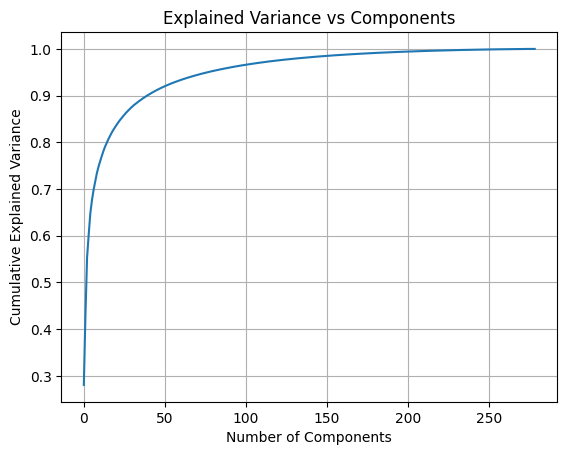

In [18]:
# X is a list or array of RGB images
X_gray = []

# this works ok, but it makes pics maybe too smooth
# for image in X:
#     gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])  # convert to grayscale
#     X_gray.append(gray)  # store grayscale image

#avrage the 3 channels
for image in X:
    gray = np.mean(image, axis=2)  # average the RGB channels
    X_gray.append(gray)  # store grayscale image

# If X is a NumPy array, you can convert the list back to an array:
X_gray = np.array(X_gray)  # shape: (num_images, height, width)

#  average image 
average_image = np.mean(X_gray, axis=0).astype(np.uint8)
averaged_X= X_gray - average_image


#flatten X shape:(image,pixel(R*G*B))
averaged_X_flattened = averaged_X.reshape(averaged_X.shape[0], -1)

# Apply PCA
pca = PCA(n_components=0.95)
pca.fit(averaged_X_flattened)
X_transformed = pca.transform(averaged_X_flattened)

# Print number of components selected
print("Number of components selected:", pca.n_components_)

# Plot cumulative explained variance for all components
pca_full = PCA().fit(averaged_X_flattened)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Components')
plt.grid(True)
plt.show()

 

# Linear Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('sfs', SequentialFeatureSelector(LinearRegression(), cv=5)),
    ('regression', LinearRegression())
])

param_grid = {
    'sfs__n_features_to_select': range(1,  25)
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error',verbose=2)
grid_search.fit(X_transformed, y)

best_num_features = grid_search.best_params_['sfs__n_features_to_select']
print(f"Best number of features: {best_num_features}")

# Extract the fitted components
sfs = grid_search.best_estimator_.named_steps['sfs']
model = grid_search.best_estimator_.named_steps['regression']
selected_features = sfs.get_support()

print("Selected features:", selected_features)

# Fit Linear Regression on selected features
X_selected = X_transformed[:, selected_features]  
model.fit(X_selected, y)

# Get coefficients and intercept
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ........................sfs__n_features_to_select=1; total time=   0.6s
[CV] END ........................sfs__n_features_to_select=1; total time=   0.6s
[CV] END ........................sfs__n_features_to_select=1; total time=   0.6s
[CV] END ........................sfs__n_features_to_select=1; total time=   0.6s
[CV] END ........................sfs__n_features_to_select=1; total time=   0.6s
[CV] END ........................sfs__n_features_to_select=2; total time=   1.3s
[CV] END ........................sfs__n_features_to_select=2; total time=   1.2s
[CV] END ........................sfs__n_features_to_select=2; total time=   0.8s
[CV] END ........................sfs__n_features_to_select=2; total time=   0.8s
[CV] END ........................sfs__n_features_to_select=2; total time=   0.7s
[CV] END ........................sfs__n_features_to_select=3; total time=   1.2s
[CV] END ........................sfs__n_feature

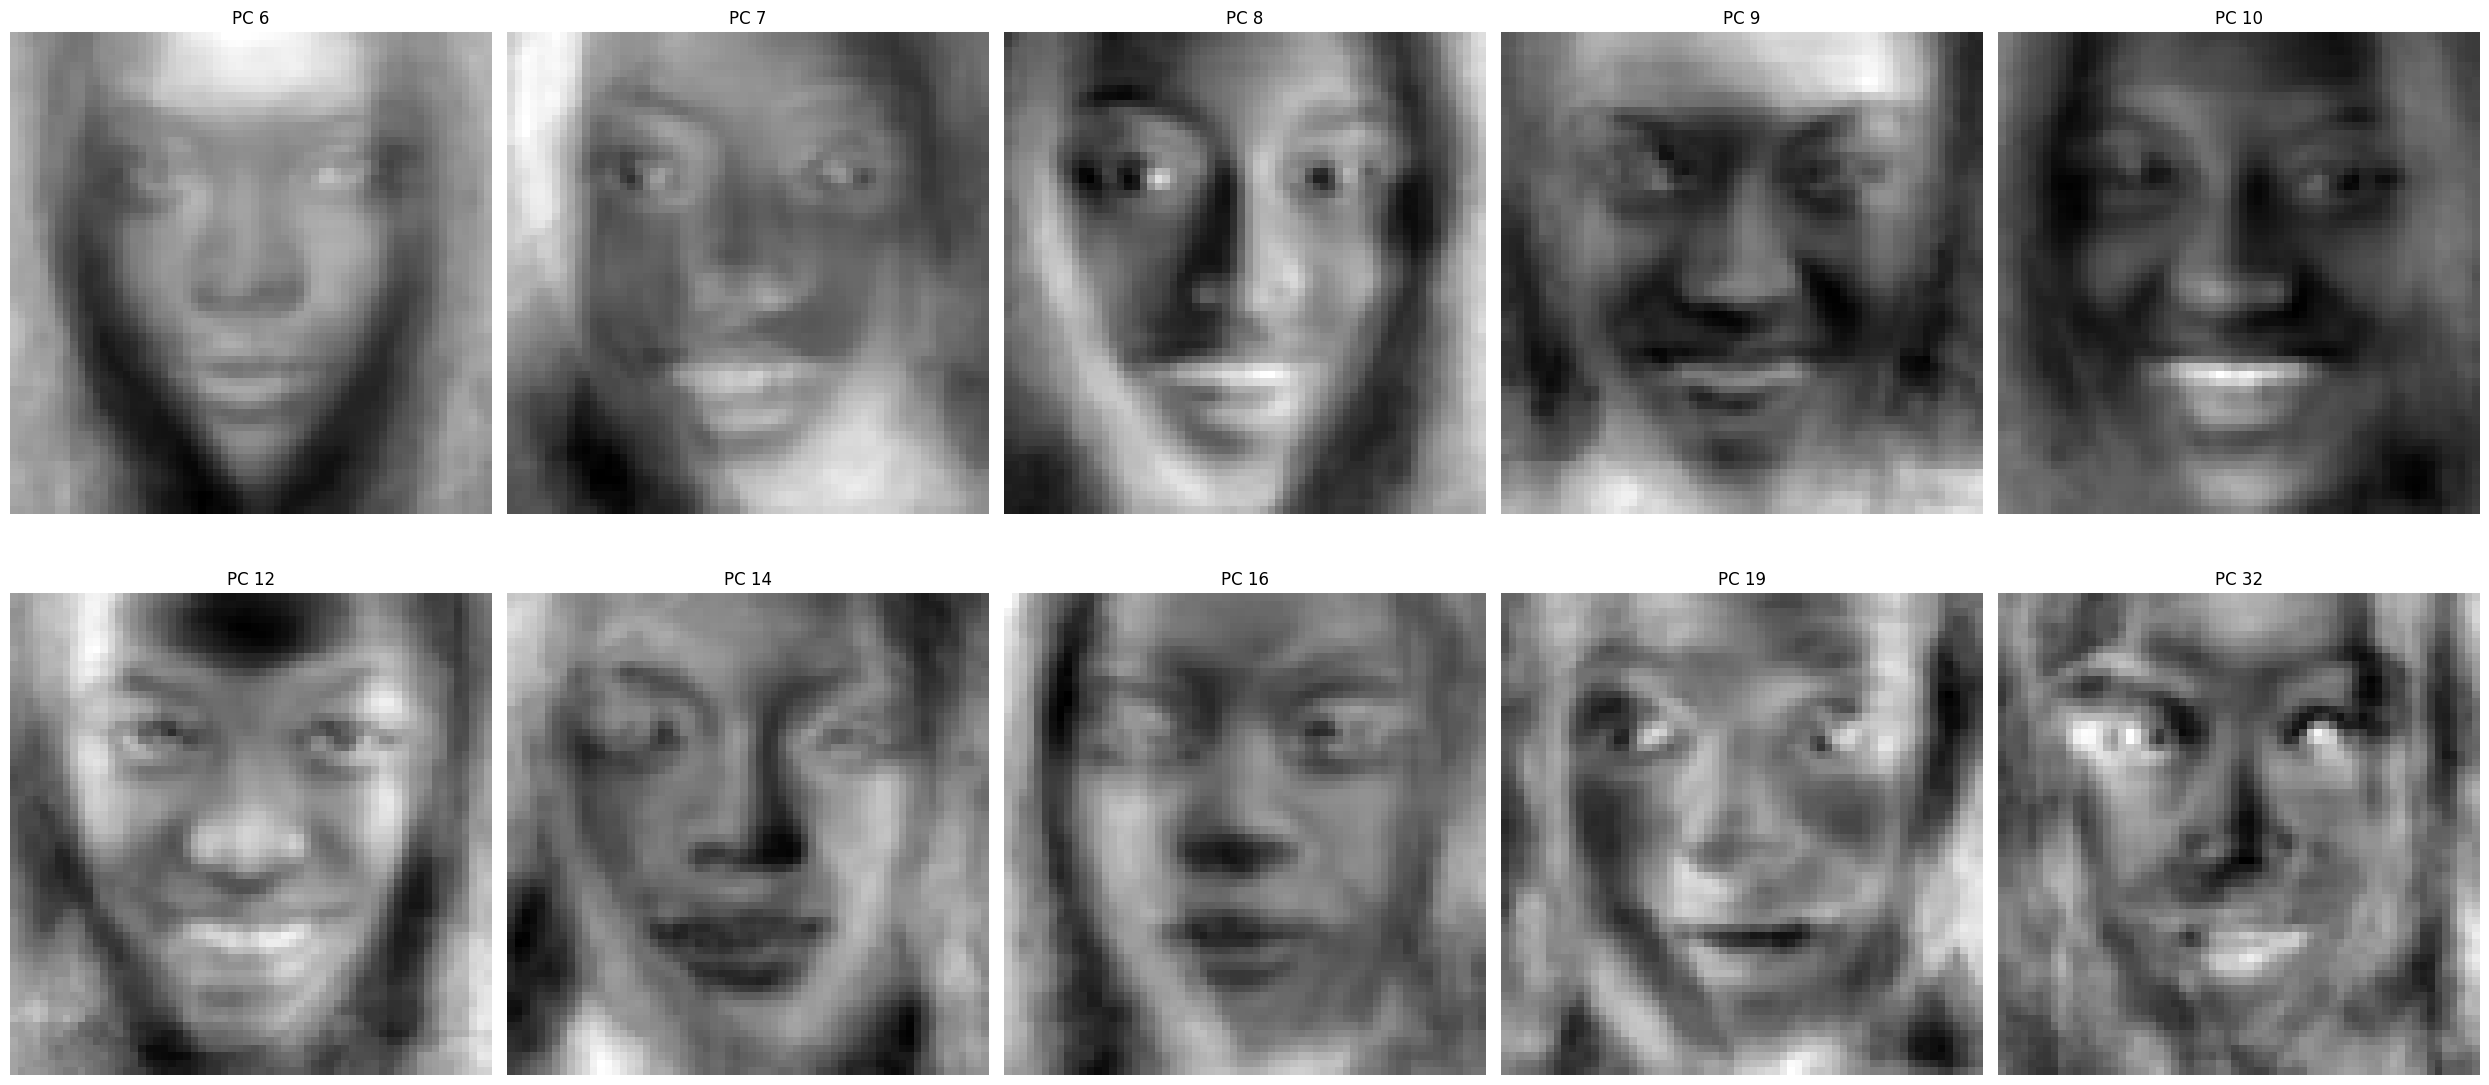

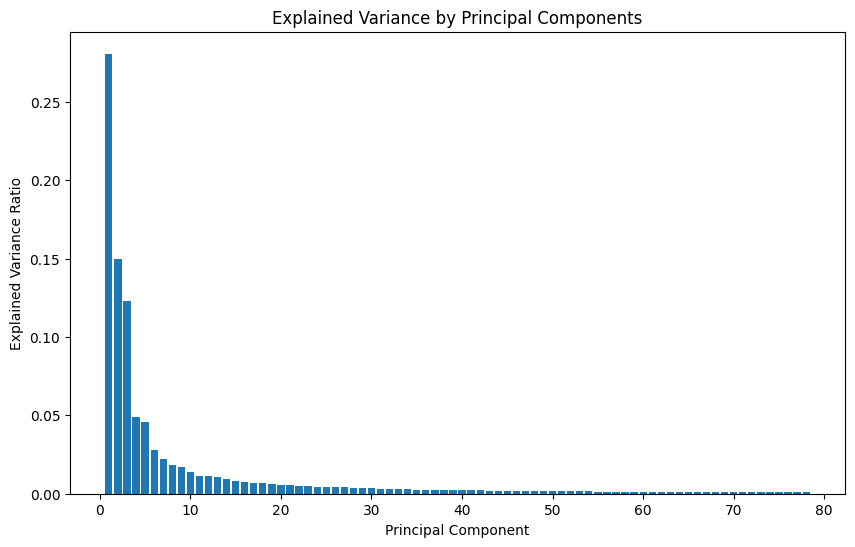

cumulative explained variance for the chosen components 0.13683839202291787


In [41]:
# images for each pc and bar plot for the variance for all pcs
# Plot the first 10 principal components in a 5x2 grid

chosen_components = sfs.get_support(indices=True)

plt.figure(figsize=(25, 12))
for i,j in enumerate(chosen_components):
    plt.subplot(2, 5, i+1)
    img = pca.components_[j].reshape(64, 64)
    plt.imshow(img, cmap='gray')
    plt.title(f'PC {j+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# bar plot of explained variance for all principal components
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

print("cumulative explained variance for the chosen components", np.sum(pca.explained_variance_ratio_[chosen_components]))

# Linear Decoding of Complex Features

In [38]:
# Ask for user input
# label = float(input("Enter the rating you desire: "))
label = 100

def create_and_save_image(label, path=f"my_image_{(label)}.png"):
# Generate artificial image from model
    image = (label - model.intercept_) * (model.coef_ / (np.linalg.norm(model.coef_)**2))

    # Inverse transform through feature selection
    image_sfs = sfs.inverse_transform(image.reshape(1, -1))

    # Inverse PCA transform
    image_pca = pca.inverse_transform(image_sfs)

    # Reshape and add the average image
    img_to_show = image_pca.reshape(64, 64) + average_image

    # Clip values to valid range for display
    img_to_show = np.clip(img_to_show, 0, 255).astype(np.uint8)

    # Display the image
    plt.imshow(img_to_show,cmap='gray')
    plt.axis('off')

    # Save the image
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()

print(f"Image for rating {label} saved successfully.")


Image for rating 100 saved successfully.


In [100]:
to_create = [i*0.5 for i in range(1, 12)]
for i in to_create:
    create_and_save_image(i, path=f"generated images/my_image_{(i)}_1.png")

First image shape (PCA space): (1, 78)


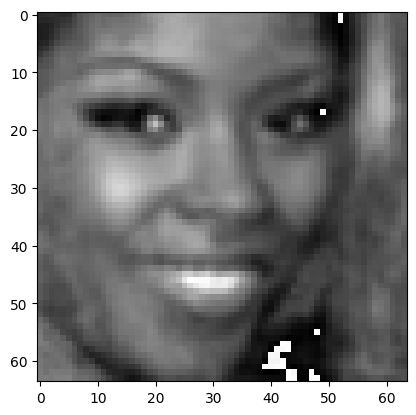

In [21]:
#First image of the dataset
first_image=averaged_X_flattened[0,:]
plt.imshow(first_image.reshape(64,64).astype(np.uint8)+average_image,cmap='gray')

first_transformed_image=pca.transform(first_image.reshape(1,-1))
first_retransfomed=pca.inverse_transform(first_transformed_image)
print("First image shape (PCA space):", first_transformed_image.shape)
plt.imshow(first_retransfomed.reshape(64,64).astype(np.uint8)+average_image,cmap='gray')




In [ ]:
# create 10 images 
for i in to_create:
    for j in range(1,11):
        create_and_save_image(i, path=f"fake images/my_image_{(i)}_{j}.png")

fake_images = os.listdir("fake images")

# Experiment 2


In [ ]:
import os
import numpy as np
from IPython.display import display, Image as IPImage

# Initialize ratings dictionary
ratings = {image: (0, 0) for image in fake_images}
num_images = len(ratings) * 2
current_image = 0
rated_images = []
rated_once_images = []
saved_file = "experiment2_s215178.txt"

# Load existing ratings if file exists
if os.path.exists(saved_file):
    with open(saved_file, "r") as f:
        for line in f:
            image, rating1, rating2 = line.strip().split(", ")
            rating1, rating2 = int(rating1), int(rating2)
            ratings[image] = (rating1, rating2)

            if rating1 != 0 and rating2 == 0:
                rated_once_images.append(image)
                current_image += 1
            elif rating1 != 0 and rating2 != 0:
                rated_images.append(image)
                current_image += 2

# Create list with each image appearing twice
shuffled_fake_images = np.random.permutation(fake_images * 2)

# Rating loop
for image in shuffled_fake_images:
    if image in rated_images:
        continue

    if image in rated_once_images:
        # Second rating
        display(IPImage(filename=os.path.join("fake images/", image)))
        rating2 = int(input(f"user 2, Rate the happiness of the person in {image} (1-5): "))

        ratings[image] = (ratings[image][0], rating2)
        rated_images.append(image)
        rated_once_images.remove(image)

        # Update file (rewrite all)
        with open(saved_file, "w") as f:
            for img, (r1, r2) in ratings.items():
                f.write(f"{img}, {r1}, {r2}\n")

        current_image += 1
        print(f"Progress: {current_image}/{num_images} images rated.")
        continue

    # First rating
    display(IPImage(filename=os.path.join("fake images/", image)))
    rating1 = int(input(f"Rate the happiness of the person in {image} (1-5): "))

    ratings[image] = (rating1, 0)
    rated_once_images.append(image)
    current_image += 1

    # Append to file
    with open(saved_file, "a") as f:
        f.write(f"{image}, {rating1}, 0\n")

    print(f"Progress: {current_image}/{num_images} images rated.")


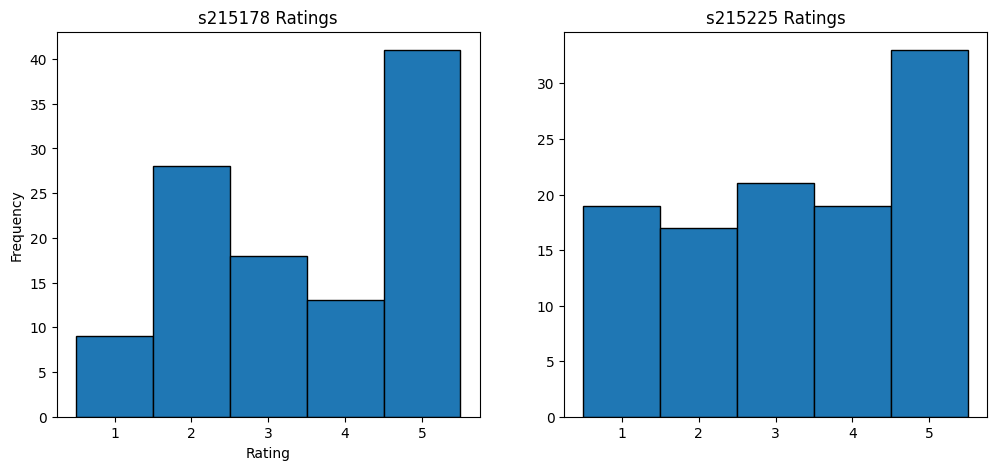

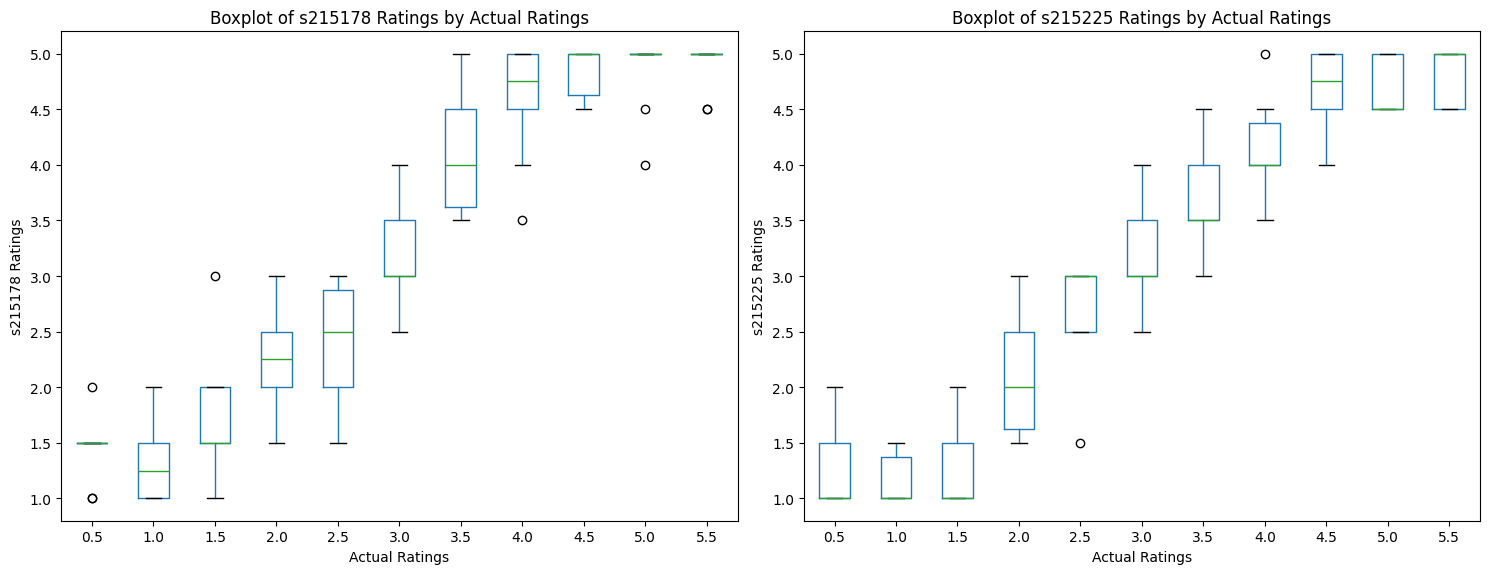

Spearman correlation (s215178): 0.9259192073447117, p-value: 4.746646958988247e-47
Spearman correlation (s215225): 0.9438084400259938, p-value: 2.892184303780668e-53
Spearman correlation (s215178 vs s215225): 0.8921723149455494, p-value: 1.007478759712065e-38


In [99]:
s215178 = pd.read_csv("experiment2_s215178.txt", sep=",")
s215225 = pd.read_csv("experiment2_s215225.txt", sep=",")

s215178_avg = s215178.iloc[:, -2:].mean(axis=1).values
s215225_avg = s215225.iloc[:, -2:].mean(axis=1).values


actual_labels = []
for image_name in s215178.iloc[:, 0]:
    label = float(image_name.split("_")[2])
    actual_labels.append(label)


# Plot histograms of ratings
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(s215178_avg, bins=np.arange(1, 7)-0.5, edgecolor='black')
axs[0].set_title('s215178 Ratings')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Frequency')
axs[1].hist(s215225_avg, bins=np.arange(1, 7)-0.5, edgecolor='black')
axs[1].set_title('s215225 Ratings')


# box plot 
# join both ratings in one dataframe
combined_df = pd.DataFrame({
    'Name': s215178.iloc[:, 0].tolist(),
    's215178': s215178_avg,
    's215225': s215225_avg,
    "actiual" : actual_labels
})

# s215178 boxplot where x axis is her ratings and y axis is the actual ratings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# s215178's boxplot
combined_df.boxplot(column='s215178', by='actiual', grid=False, ax=ax1)
ax1.set_title('Boxplot of s215178 Ratings by Actual Ratings')
ax1.set_xlabel('Actual Ratings')
ax1.set_ylabel('s215178 Ratings')

# s215225's boxplot
combined_df.boxplot(column='s215225', by='actiual', grid=False, ax=ax2)
ax2.set_title('Boxplot of s215225 Ratings by Actual Ratings')
ax2.set_xlabel('Actual Ratings')
ax2.set_ylabel('s215225 Ratings')

plt.suptitle('')  # This removes the automatic suptitle
plt.tight_layout()
plt.show()


# spearman correlation
from scipy.stats import spearmanr
spearman_s215178 = spearmanr(actual_labels, s215178_avg)
spearman_s215225 = spearmanr(actual_labels, s215225_avg)
spearmanr_both = spearmanr(s215178_avg, s215225_avg)
print(f"Spearman correlation (s215178): {spearman_s215178.correlation}, p-value: {spearman_s215178.pvalue}")
print(f"Spearman correlation (s215225): {spearman_s215225.correlation}, p-value: {spearman_s215225.pvalue}")
print(f"Spearman correlation (s215178 vs s215225): {spearmanr_both.correlation}, p-value: {spearmanr_both.pvalue}")


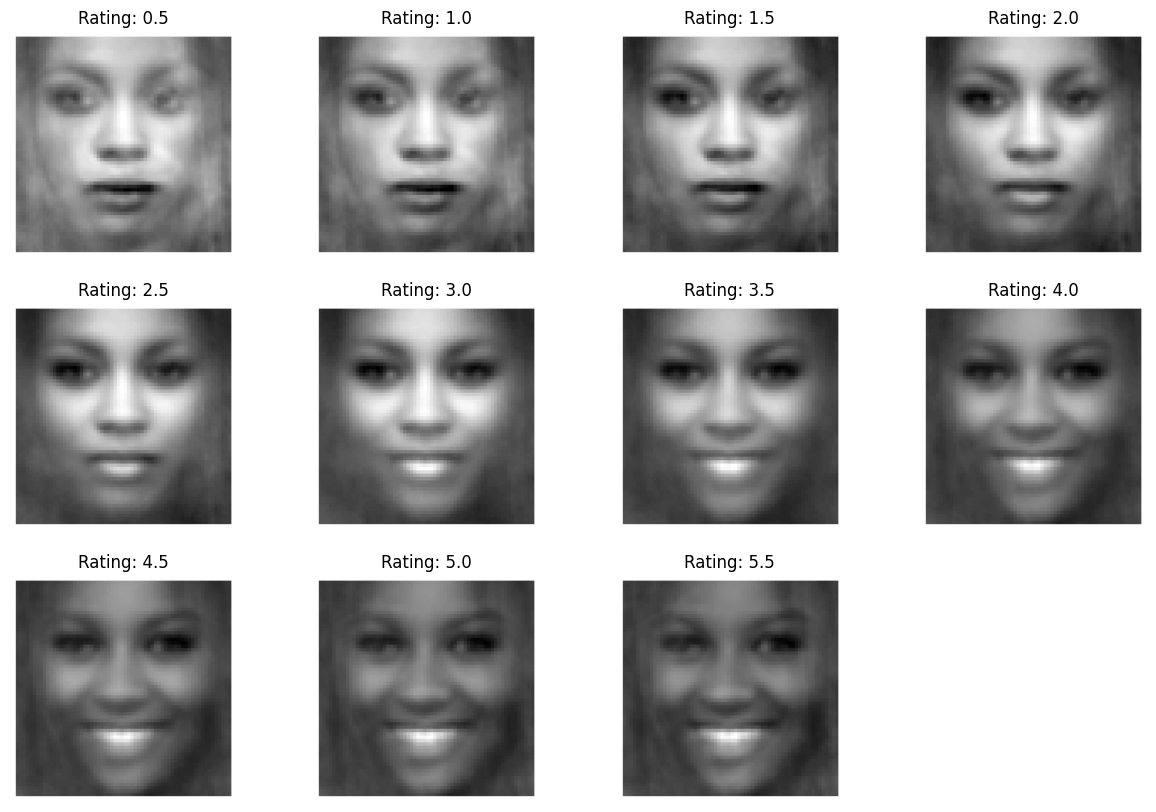

In [63]:
# plot the 11 fake images in a 3x4 grid
to_create = [i*0.5 for i in range(1, 12)]
plt.figure(figsize=(15, 10))
for idx, i in enumerate(to_create):
    img_path = f"fake images/my_image_{(i)}_1.png"
    img = IPImage(filename=img_path)
    plt.subplot(3, 4, idx + 1)
    plt.imshow(plt.imread(img_path), cmap='gray')
    plt.title(f'Rating: {i}')
    plt.axis('off')